<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v2/Conv_VAE_Novel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [19]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Import Data and plot it

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled    

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_mean = tf.math.sigmoid(pixel_output)
        return pixel_mean

#### Define the loss function 

In [0]:
def calculate_KL(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    return KL

def calculate_logpx_z(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    return logpx_z

def calculate_ELBO(model, x):
    logpx_z = calculate_logpx_z(model, x)
    KL = calculate_KL(model, x)
    
    ELBO = logpx_z - KL 
    return -ELBO #Negative because we want to maximise it

In [0]:
def calculate_logpx_z_mean(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    return logpx_z

def calculate_pixel_squared(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

def calculate_pixel_squared_mean(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

In [0]:
def calculate_ssim(model, x):
  z_mean, z_logvar = model.encode(x)
  z = model.reparameterize(z_mean, z_logvar)
  y = model.decode(z)

  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  ssim = tf.image.ssim(x[:,:,:,:],y[:,:,:,:], input_range, filter_size=11,filter_sigma=0.1,k1=0.1,k2=0.01)
  ssim = tf.reduce_mean(ssim)
  return (1-ssim)*1000

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [0]:
mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

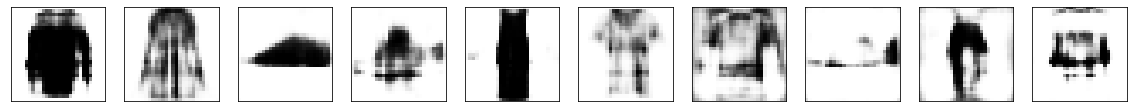

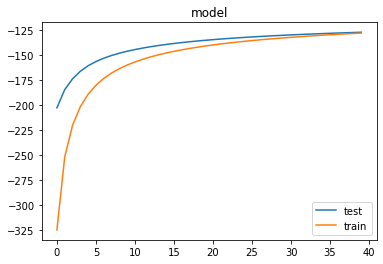

In [33]:
x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7])


z_size = 25
model_nov = CVAE(z_size)

train_test_dataset(model_nov, train_dataset_0, test_dataset_0, 40, generate=True)

#### Reconstruct images

Original Pictures:


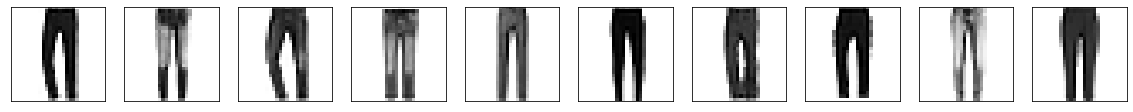

Reconstructed Pictures, with ELBO loss:


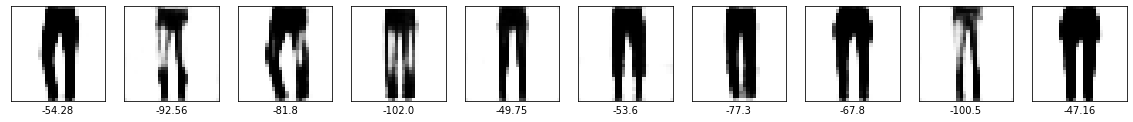

In [34]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_nov, x_test[1000:1010])

#### Visualize the latent space

0 Outliers detected


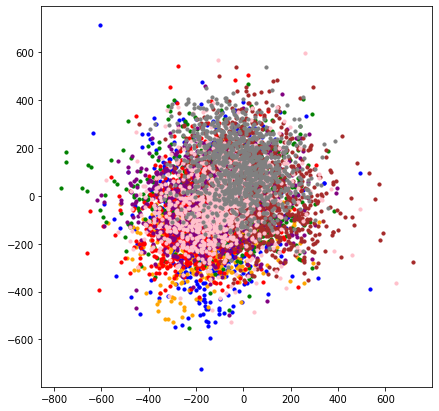

In [35]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  latent_space = np.zeros([range2-range1,2, 25])
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    latent_space[i,0,:] = z_mean
    latent_space[i,1,:] = z_logvar
    
    if any(z_logvar[:,i]>10 for i in range(z_size)):
      outliers +=1
      outlier.append(i)
      continue
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  print('{} Outliers detected'.format(outliers))
  return latent_space, outlier

latent_space, outlier = visualize_latent_space(model_nov, 0, len(x_test_0), x_test_0, y_test_0, 0,1)

In [36]:
print(np.shape(latent_space))
np.save('/content/drive/My Drive/4YP/latent_space_nov.npy',latent_space)

(8000, 2, 25)


#### Check reconstruction performance for untrained classes and create table of losses


,0,1,2,3,4,5,6,7,8,9
ELBO,117.90,78.44,121.11,107.62,110.03,133.39,136.06,96.38,219.74,152.49
Recon_likelihood,86.79,50.70,87.87,78.62,78.89,101.48,104.74,69.52,177.02,109.91
KL_divergence,31.10,27.78,33.28,28.85,31.19,31.85,31.46,26.70,42.98,42.60
Recon_error,26.65,15.20,26.78,24.30,23.84,31.67,32.35,21.16,51.69,33.16
SSIM,5.83,5.58,5.88,5.68,5.85,5.54,5.87,5.53,5.82,5.78


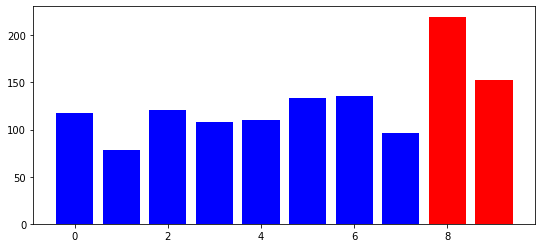

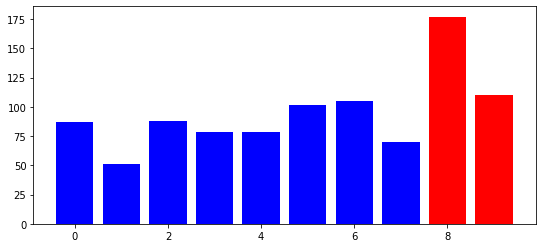

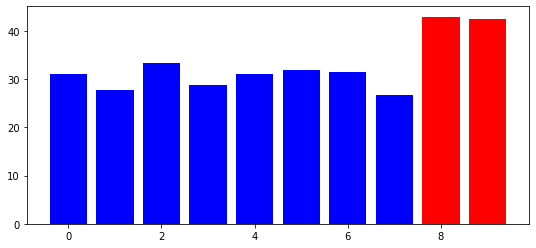

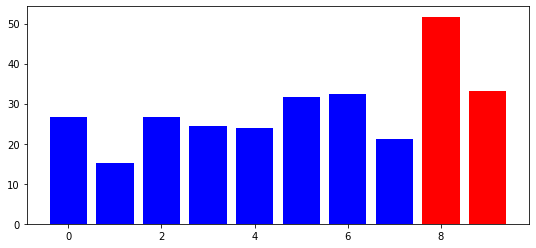

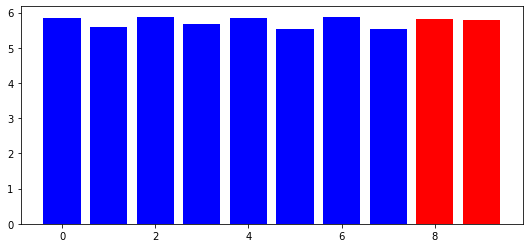

In [0]:
table_of_losses = np.zeros([N_class, 5])
for i in range(1):
  model = model_nov
  #print('Model trained with class {}'.format(i))
  plt.figure(1, figsize=[9,4])
  plt.figure(2, figsize=[9,4])
  plt.figure(3, figsize=[9,4])
  plt.figure(4, figsize=[9,4])
  plt.figure(5, figsize=[9,4])
  for j in range(N_class):
    test_images = x_train[(y_train==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    ELBO_loss = calculate_ELBO(model, test_images)
    logpx_z_loss = calculate_logpx_z_mean(model, test_images)
    KL_loss = calculate_KL(model, test_images)
    pixel_squared_loss = calculate_pixel_squared(model,test_images)
    #print(pixel_squared_loss)
    ssim_loss = compute_recon_DB_loss(x_train[(y_train==j)], x_train_0)
    ssim_loss = np.mean(ssim_loss)
    #print(ssim_loss)
    table_of_losses[j,0] = ELBO_loss
    table_of_losses[j,1] = -logpx_z_loss
    table_of_losses[j,2] = KL_loss
    table_of_losses[j,3] = pixel_squared_loss
    table_of_losses[j,4] = ssim_loss
    if j==8 or j==9:
      color='red'
    else:
      color='blue'
    plt.figure(1)
    plt.bar(j,ELBO_loss.numpy(),color=color)
    plt.figure(2)
    plt.bar(j,-logpx_z_loss.numpy(),color=color)
    plt.figure(3)
    plt.bar(j,KL_loss.numpy(),color=color)
    plt.figure(4)
    plt.bar(j,pixel_squared_loss.numpy(),color=color)
    plt.figure(5)
    plt.bar(j,ssim_loss,color=color)

#for i in range(N_class):
#    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
 
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(np.transpose(table_of_losses), decimals=2), index=['ELBO', 'Recon_likelihood', 'KL_divergence', 'Recon_error', 'SSIM'])
table_loss


### Calculate novelty losses scores

In [0]:
def compute_losses(x):
  losses_per_image = np.zeros([len(x),5])
  for i in range(len(x)):
    if not i%10:
      clear_output()
      print('Progress:{}%'.format(100*(i)/len(x)))
    image = x[i]/input_range
    image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    loss1,loss2,loss3 = calculate_ELBO(model_nov, image)
    loss4 = calculate_pixel_squared(model_nov, image)
    loss5 = calculate_ssim(model_nov, image)
    losses_per_image[i,0]= loss1
    losses_per_image[i,1]= -loss2
    losses_per_image[i,2]= loss3
    losses_per_image[i,3]= loss4
    losses_per_image[i,4]= loss5
  return losses_per_image

In [0]:
losses_per_image_test = compute_losses(x_test)
losses_per_image_train = compute_losses(x_train)

In [0]:
train_losses_novel = np.load('/content/drive/My Drive/4YP/train_losses_novel.npy')
test_losses_novel = np.load('/content/drive/My Drive/4YP/test_losses_novel.npy')

In [0]:
def compute_recon_error_loss(x):
  losses_per_image = np.zeros([len(x),])
  for i in range(len(x)):
    if not i%500: clear_output(); print('Progress recon_error_loss:{}%'.format(100*(i)/len(x)))
    image = set_pixels_binary(x[i]); image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    losses_per_image[i]= calculate_pixel_squared_mean(model_nov, image)
  return losses_per_image

def compute_recon_error_loss_stoch(x):
  losses_per_image = np.zeros([len(x),])
  avg = np.zeros([10])
  for i in range(len(x)):
    if not i%50: clear_output(); print('Progress recon_error_loss_stoch:{}%'.format(100*(i)/len(x)))
    image = set_pixels_binary(x[i]); image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    for j in range(10):
      avg[j] = calculate_pixel_squared(model_nov, image)
    losses_per_image[i]= np.mean(avg)
  return losses_per_image

def compute_recon_likelihood(x):
  losses_per_image = np.zeros([len(x),])
  for i in range(len(x)):
    if not i%500: clear_output(); print('Progress recon_likelihood:{}%'.format(100*(i)/len(x)))
    image = set_pixels_binary(x[i]); image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    losses_per_image[i]= calculate_logpx_z_mean(model_nov, image)
  return losses_per_image

def compute_ELBO(x):
  losses_per_image = np.zeros([len(x),])
  for i in range(len(x)):
    if not i%500: clear_output(); print('Progress ELBO:{}%'.format(100*(i)/len(x)))
    image = set_pixels_binary(x[i]); image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    losses_per_image[i]= calculate_ELBO(model_nov, image)
  return losses_per_image

def compute_KL_loss(x):
  losses_per_image = np.zeros([len(x),])
  for i in range(len(x)):
    if not i%500: clear_output(); print('Progress KL_loss:{}%'.format(100*(i)/len(x)))
    image = set_pixels_binary(x[i]); image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    losses_per_image[i]= calculate_KL(model_nov, image)
  return losses_per_image

def compute_12_loss(x_test, x_train):
  losses_x_test = compute_recon_error_loss(x_test)
  losses_x_train = compute_recon_error_loss(x_train)
  losses_per_image = np.zeros([len(losses_x_test),])
  for i in range(len(losses_x_test)):
    temporary = np.abs(np.subtract(losses_x_test[i], losses_x_train))
    losses_per_image[i] = np.min(temporary)
  return losses_per_image

In [39]:
losses_recon_error_test = compute_recon_error_loss(x_test)
np.save('/content/drive/My Drive/4YP/losses_recon_error_test.npy',losses_recon_error_test)

#losses_recon_error_stoch_test = compute_recon_error_loss_stoch(x_test)
#np.save('/content/drive/My Drive/4YP/losses_recon_error_stoch_test.npy',losses_recon_error_stoch_test)

losses_recon_likelihood_test = compute_recon_likelihood(x_test)
np.save('/content/drive/My Drive/4YP/losses_recon_likelihood_test.npy',losses_recon_likelihood_test)

losses_ELBO_test = compute_ELBO(x_test)
np.save('/content/drive/My Drive/4YP/losses_ELBO_test.npy',losses_ELBO_test)

losses_KL_test = compute_KL_loss(x_test)
np.save('/content/drive/My Drive/4YP/losses_KL_test.npy',losses_KL_test)

losses_12 = compute_12_loss(x_test, x_train_0)
np.save('/content/drive/My Drive/4YP/losses_12.npy',losses_12)

Progress recon_error_loss:98.96039500822934%


In [40]:
def compute_recon_DB_loss(test, train):
  test = test.reshape([len(test), 28, 28, 1])
  train = train.reshape([len(train), 28, 28, 1])
  pixel_prob_train = np.zeros(np.shape(train))
  pixel_prob_test = np.zeros(np.shape(test))
  for i in range(len(train)//10000+1):
    z_mean, z_logvar = model_nov.encode(train[10000*i:10000*i+10000])
    pixel_prob_train[10000*i:10000*i+10000] = model_nov.decode(z_mean)
  for i in range(len(test)//10000+1):
    z_mean, z_logvar = model_nov.encode(test[10000*i:10000*i+10000])
    pixel_prob_test[10000*i:10000*i+10000] = model_nov.decode(z_mean)
  pixel_prob_train = tf.reduce_sum(pixel_prob_train, axis=[1, 2, 3])
  pixel_prob_test = tf.reduce_sum(pixel_prob_test, axis=[1, 2, 3])
  
  losses_per_image = np.zeros([len(pixel_prob_test),])
  for i in range(len(pixel_prob_test)):
    temporary = np.sqrt(np.multiply(1-pixel_prob_test[i],np.subtract(1,pixel_prob_train)))+np.sqrt(np.multiply(pixel_prob_test[i],pixel_prob_train))
    temporary = np.log(temporary)
    losses_per_image[i] = np.min(temporary)

  return losses_per_image

losses_recon_DB = compute_recon_DB_loss(x_test, x_train_0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [44]:
def compute_z_distance_loss(test, train):
  losses_per_image = np.zeros([len(test),])
  z_mean_test = np.zeros([len(test),])
  z_mean_train = np.zeros([len(train),])
  for i in range(len(test)):
    if not i%500: clear_output(); print('Progress test:{}%'.format(100*(i)/len(test)))
    image_test = set_pixels_binary(test[i]); image_test = image_test.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    z_mean, _ = model_nov.encode(image_test)
    z_mean_test[i] = z_mean
  for i in range(len(train)):
    if not i%500: clear_output(); print('Progress train:{}%'.format(100*(i)/len(train)))
    image_train = set_pixels_binary(train[i]); image_train = image_train.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    z_mean, _ = model_nov.encode(image_train)
    z_mean_train[i] = z_mean 
  for i in range(len(test)):
    temporary = np.subtract(z_mean_test[i], z_mean_train)
    losses_per_image[i] = np.min(np.square(temporary))
  return losses_per_image

z_distance_loss = compute_z_distance_loss(x_test, x_train_0)

Progress test:0.0%


ValueError: ignored

### Predict classes

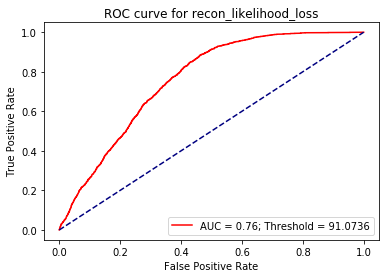

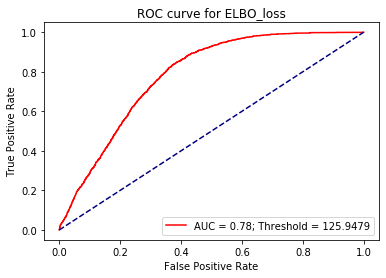

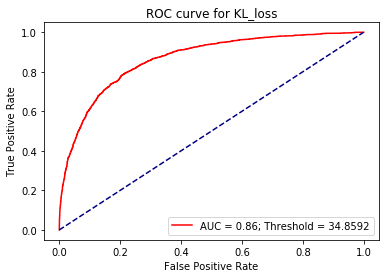

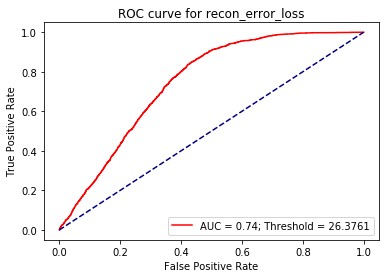

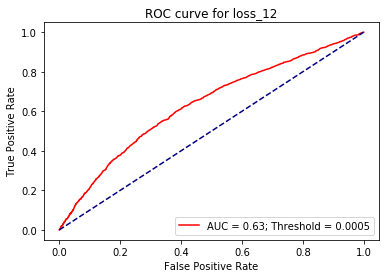

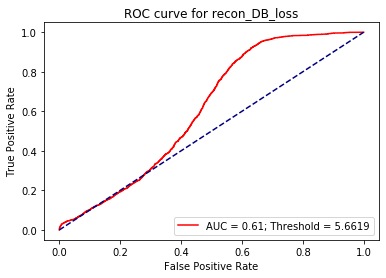

In [42]:
y_true = np.zeros([len(y_test),])
unnovel_idx = np.where(y_test < 8)
novel_idx = np.where(y_test >= 8)
y_true[unnovel_idx] = 0
y_true[novel_idx] = 1

def threshold_ROC(y_true, y_score, title):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]
  plot = plt.figure()
  plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for ' + title)
  plt.legend(loc="lower right")
  plt.show()
  optimal_threshold

threshold_ROC(y_true, -losses_recon_likelihood_test, 'recon_likelihood_loss')
threshold_ROC(y_true, losses_ELBO_test, 'ELBO_loss')
threshold_ROC(y_true, losses_KL_test, 'KL_loss')
threshold_ROC(y_true, losses_recon_error_test, 'recon_error_loss')
#threshold_ROC(y_true, losses_recon_error_stoch_test, 'recon_error_stoch_loss')
threshold_ROC(y_true, losses_12, 'loss_12')
threshold_ROC(y_true, losses_recon_DB, 'recon_DB_loss')

In [0]:
train_losses_novel_known = train_losses_novel[np.where(y_train < 8)]
train_losses_novel_novel = train_losses_novel[np.where(y_train >= 8)]

averages = []; avrg_batch = 50
for i in range(len(train_losses_novel_known)-avrg_batch):
  averages.append(np.mean(train_losses_novel_known[i:i+avrg_batch], axis=0))

thresholds = np.max(averages, axis=0)

predictions = np.zeros([len(test_losses_novel),])
for i in range(len(test_losses_novel)):
  if test_losses_novel[i,3] >= thresholds[3]:
    predictions[i] = 1
  if test_losses_novel[i,3] < thresholds[3]:
    predictions[i] = 0

wrong_novel=0; correct_known=0; correct_novel=0; wrong_known=0

for i in range(len(predictions)):
  if predictions[i]==1:
    if y_test[i] < 8:
      wrong_novel += 1
    if y_test[i] >= 8:
      correct_novel +=1
  if predictions[i]==0:
    if y_test[i] < 8:
      correct_known +=1
    if y_test[i] >= 8:
      wrong_known +=1

accuracy = (correct_known+correct_novel)/(len(predictions))
print(100*correct_novel/2000)
print(100*accuracy)

63.15
82.25


### Find classes

In [0]:
def losses_softmax(x):
  x_normalized = np.zeros(np.shape(x))
  softmax_probabilities = np.zeros(np.shape(x))
  for i in range(len(x)):
    x_normalized[i,:] = x[i,:]/np.min(x[i,:])
    x_normalized[i,:] = np.multiply(x_normalized[i,:],-2)
    e_x = np.exp(x_normalized)
    softmax_probabilities[i,:] = (np.exp(x_normalized[i,:]) / np.exp(x_normalized[i,:]).sum())*100
  return softmax_probabilities

In [0]:
softmax_probabilities_test = losses_softmax(losses_per_image_test)
softmax_probabilities_train = losses_softmax(losses_per_image_train)

### Classify using highest softmax probability

In [0]:
def classify_highest_softmax(x):
  predicted_class = np.zeros([len(x)],)
  for i in range(len(x)):
    predicted_class[i] = np.argmax(x[i,:])
  return predicted_class

In [0]:
predicted_class_1 = classify_highest_softmax(softmax_probabilities_test)

#### Classify using ROC curves

In [0]:
def ROC_thresholds(y, prob_x, plot_ROC_curves=1):
  y_true = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_true[y[i].astype('int'),i]=1 #each row has all the images, each row is a class. Values are 1 where the image corresponds to that class

  y_score = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_score[:,i] = prob_x[i] #each column is the softmax distribution for each image

  
  optimal_thresholds = np.zeros([10,])
  for i in range(10):
    fpr, tpr, threshold = roc_curve(y_true[i,:], y_score[i,:])
    optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = threshold[optimal_idx]
    optimal_thresholds[i] = optimal_threshold
    if plot_ROC_curves == 1:
      plot = plt.figure()
      plt.plot(fpr, tpr, color='red')
      plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curve for class '+str(i))
      plt.show()
  return optimal_thresholds

In [0]:
optimal_thresholds = ROC_thresholds(y_test, softmax_probabilities_test, 0)

In [0]:
def classify_ROC_thresholds(prob_x, thresholds, y):
  predicted_class = np.zeros([len(y),])
  for i in range(len(y)):
    diff = prob_x[i,:]-thresholds
    predicted_class[i]=np.argmax(diff)
  return predicted_class

In [0]:
predicted_class_2 = classify_ROC_thresholds(softmax_probabilities_test, optimal_thresholds, y_test)

### Classify using a NN classifier

In [0]:
from sklearn.utils import class_weight

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(128, activation= tf.nn.relu)
    self.d2 = tf.keras.layers.Dense(128, activation= tf.nn.relu)
    self.d3 = tf.keras.layers.Dense(10, activation = tf.nn.softmax)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return x

model = MyModel()

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

model.fit(losses_per_image_train, y_train, batch_size=50, epochs=20, class_weight=class_weights, validation_data=(losses_per_image_test, y_test), shuffle=True)
model.evaluate(losses_per_image_test, y_test, verbose=2)

Train on 17165 samples, validate on 10000 samples
Epoch 1/20
17165/17165 [==============================] - 3s 155us/sample - loss: 30.0355 - accuracy: 0.5486 - val_loss: 1092.4309 - val_accuracy: 0.4995
Epoch 2/20
17165/17165 [==============================] - 2s 107us/sample - loss: 11.7232 - accuracy: 0.6615 - val_loss: 749.6966 - val_accuracy: 0.3649
Epoch 3/20
17165/17165 [==============================] - 2s 106us/sample - loss: 7.1429 - accuracy: 0.6986 - val_loss: 846.0963 - val_accuracy: 0.5682
Epoch 4/20
17165/17165 [==============================] - 2s 104us/sample - loss: 5.3050 - accuracy: 0.7304 - val_loss: 1732.1148 - val_accuracy: 0.4752
Epoch 5/20
17165/17165 [==============================] - 2s 106us/sample - loss: 6.5025 - accuracy: 0.7161 - val_loss: 937.0735 - val_accuracy: 0.5911
Epoch 6/20
17165/17165 [==============================] - 2s 105us/sample - loss: 2.6884 - accuracy: 0.7672 - val_loss: 717.9117 - val_accuracy: 0.6395
Epoch 7/20
17165/17165 [==========

[1.4148480807781219, 0.6122]

In [0]:
predicted_class_3 = np.argmax(model(losses_per_image_test), axis=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



#### Check accuracy and plot misslabeled images

In [0]:
def compute_accuracy(predictions, y):
  predictions = predictions.astype('int')
  y = y.astype('int')

  wrong_guesses = []
  table_of_counts = np.zeros([N_class+1, N_class+1])
  for i in range(len(predictions)):
    table_of_counts[y[i], predictions[i]]+=1
    if y[i] != predictions[i]:
        wrong_guesses.append(i)
  
  for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')
  for i in range(N_class):
    table_of_counts[-1,i] = np.sum(table_of_counts[0:10,i])-table_of_counts[i,i]

  index = list(str('-') * (N_class+1))
  columns = list(str('-') * (N_class+1))
  for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
  index[-1] = 'False Positives'
  columns[-1] = 'Percentage'
  table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

  accuracy = 100*table_of_counts.trace()/np.sum(table_of_counts[0:10,0:10])
  average_accuracy = np.sum(table['Percentage'])/10

  return table, accuracy, average_accuracy, wrong_guesses

In [0]:
table_1, accuracy_1, average_accuracy_1, wrong_guesses_1 = compute_accuracy(predicted_class_1, y_test)
table_2, accuracy_2, average_accuracy_2, wrong_guesses_2 = compute_accuracy(predicted_class_2, y_test)
table_3, accuracy_3, average_accuracy_3, wrong_guesses_3 = compute_accuracy(predicted_class_3, y_test)

In [0]:
print(accuracy_3)
table_3

In [0]:
# Convolutional VAE for each class results in accuracy of 98.16% with z_size = 10
# Convolutional VAE for each class results in accuracy of 89.90% with z_size = 2

In [0]:
import pandas as pd
table_same = pd.read_csv('/content/drive/My Drive/4YP/table_same.csv')
table_increase = pd.read_csv('/content/drive/My Drive/4YP/table_increase.csv')
table_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_decrease.csv')
table_loss_same = pd.read_csv('/content/drive/My Drive/4YP/table_loss_same.csv')
table_loss_increase = pd.read_csv('/content/drive/My Drive/4YP/table_loss_increase.csv')
table_loss_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_loss_decrease.csv')
predicted_prob_same = np.load('/content/drive/My Drive/4YP/predicted_prob_same.npy')
predicted_prob_increase = np.load('/content/drive/My Drive/4YP/predicted_prob_increase.npy')
predicted_prob_decrease = np.load('/content/drive/My Drive/4YP/predicted_prob_decrease.npy')
losses_per_image_test = np.load('/content/drive/My Drive/4YP/losses_per_image_test.npy')
losses_per_image_train = np.load('/content/drive/My Drive/4YP/losses_per_image_train.npy')

### Classifier

In [0]:
def find_loss_probs(losses_per_image, y):
  covariances = []
  means = []
  for i in range(N_class):
    losses = losses_per_image[y==i]
    covariance = np.cov(np.transpose(losses[:,i]))
    mean = np.mean(losses[:,i], axis=0)
    covariances.append(covariance)
    means.append(mean)
  return means, covariances

In [0]:
means, covariances = find_loss_probs(losses_per_image_train, y_train)

In [0]:
losses_distribution_dict = {}
for i in range(N_class):
  losses_distribution_dict[str(i)] = multivariate_normal(mean=means[i], cov=covariances[i])

In [0]:
max_losses_distribution = np.zeros([10,])
for i in range(10): 
  max_losses_distribution[i] = losses_distribution_dict[str(i)].pdf(means[i])

cdf_value = np.zeros([len(y_test),10])
predicted_class_4 = np.zeros([len(y_test)])
for j in range(len(y_test)):
  for i in range(10):
    cdf_value[j,i] = losses_distribution_dict[str(i)].cdf(losses_per_image_test[j,i])
    cdf_value[j,i] = 1-cdf_value[j,i]
    #cdf_value[i] = pdf_value[i]/max_losses_distribution[i]
  predicted_class_4[j] = np.argmax(cdf_value[j,:])
predicted_class_4 = predicted_class_4.astype('int')

In [0]:
table_4, accuracy_4, average_accuracy_4, wrong_guesses_4 = compute_accuracy(predicted_class_4, y_test)
print(average_accuracy_4)
table_4

0.740234375


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,51.0,650.0,0.0,0.0,0.0,0.0,0.0,299.0,0.0,0.0,5.101562
Class 1,11.0,23.0,0.0,0.0,0.0,1.0,0.0,965.0,0.0,0.0,2.300781
Class 2,588.0,305.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.0,0.000000
Class 3,15.0,181.0,0.0,0.0,0.0,0.0,0.0,804.0,0.0,0.0,0.000000
Class 4,601.0,269.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,0.000000
Class 5,135.0,863.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000
Class 6,361.0,410.0,0.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.000000
Class 7,159.0,841.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Class 8,744.0,190.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.000000
Class 9,741.0,259.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
